# X-Ray Classification with MONAI
We will be working with the pneumonia dataset [1], which can be found on kaggle. The dataset itself is 1Gb, while the kaggle dataset includes the same dataset twice, so you would only need to extract the chest_xray folder from the zip file after you download it.
- Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- Download and extract the chest_xray folder into the current working directory.

[1] Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

This next cell will check to see if monai is installed, and if it isn't it will install it.

In [1]:
!python -c "import monai" || pip install -q "monai[pillow, tqdm]==0.9.1"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

# Imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai import config
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data.utils import no_collation
from monai.data import DataLoader, PILReader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsChannelFirst,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    Lambda,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    Resize,
    ScaleIntensity,
    SqueezeDim,
    ToTensor,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1
Numpy version: 1.22.4
Pytorch version: 1.13.0a0+08820cb
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.1
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.14.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Config and Hyperparameters

In [3]:
set_determinism(seed=0)
root_dir = "./"
train_dir = "./chest_xray/train"
val_dir = "./chest_xray/val"
test_dir = "./chest_xray/test"
input_image_size = (224,224)

# Load Data

In [4]:
all_x = []
all_y = []
for data_dir in [train_dir, val_dir, test_dir]:
    class_names = sorted(x for x in os.listdir(data_dir)
                         if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names)
    image_files = [
        [
            os.path.join(data_dir, class_names[i], x)
            for x in os.listdir(os.path.join(data_dir, class_names[i]))
            if x.endswith("jpeg")
        ]
        for i in range(num_class)
    ]
    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = []
    image_class = []
    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size

    print(f"Total image count: {num_total}")
    print(f"First image dimensions: {image_width} x {image_height}")
    print(f"Label names: {class_names}")
    print(f"Label counts: {num_each}")
    
    all_x += [image_files_list]
    all_y += [image_class]

train_x, val_x, test_x = all_x
train_y, val_y, test_y = all_y
print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Total image count: 5216
First image dimensions: 1596 x 1233
Label names: ['NORMAL', 'PNEUMONIA']
Label counts: [1341, 3875]
Total image count: 16
First image dimensions: 1736 x 1416
Label names: ['NORMAL', 'PNEUMONIA']
Label counts: [8, 8]
Total image count: 624
First image dimensions: 2271 x 1827
Label names: ['NORMAL', 'PNEUMONIA']
Label counts: [234, 390]
Training count: 5216, Validation count: 16, Test count: 624


# Open a few images to check

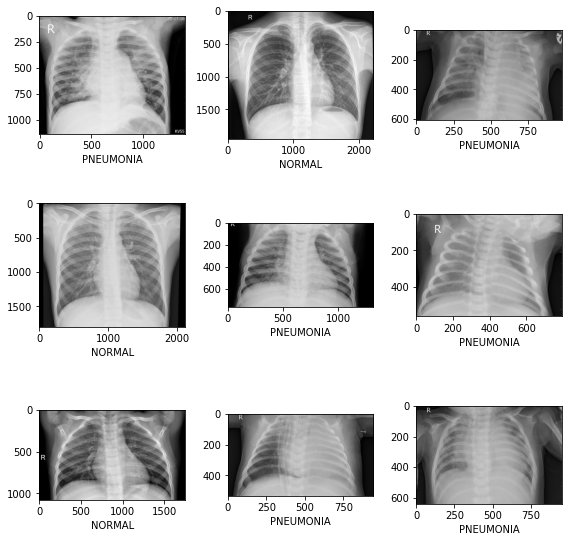

In [5]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Build Transforms
1. For both train and validation transforms, we want to load the image, then if the image is in RGB convert it to Grayscale.
2. Then we expand the dimensions so that the image will have a channel dimension, and we'll scale the intensity of the images.
3. Then for the training transforms, we can add a few random rotates, flips and zooms for augmentation.
4. Finally, both transforms should contain a resize that resizes the images to the same size.

In [6]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        Lambda(func=lambda x: np.mean(x, axis=2) if len(x.shape) >= 3 else x),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        Resize(spatial_size=input_image_size),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True),
        Lambda(func=lambda x: np.mean(x, axis=2) if len(x.shape) >= 3 else x),
        AddChannel(),
        ScaleIntensity(),
        Resize(spatial_size=input_image_size),
    ]
)

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

# Create Dataset and DataLoader
Next, we'll combine the transforms and the data into datasets, and instantiate a DataLoader that will batch the data for us.

In [7]:
class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = PneumoniaDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=4, collate_fn=None)

val_ds = PneumoniaDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=32, num_workers=4, collate_fn=None)

test_ds = PneumoniaDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=32, num_workers=4, collate_fn=None)

# Create Model
Here we will initialize a DenseNet121 using cross entropy loss. We'll also instantiate the adam optimizer with a learning rate of 1e-5. I've put a max_epoch 4 here as a sample, but you may increase it for your own experiments.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

# Train Model
This is the training steps for the model.
The model is put into training mode, and the data is loaded using the DataLoader that was defined. After each epoch, depending on the val_interval set, the model will be put into evaluation mode and inference will be performed, while the best model will be saved and its AUC will be recorded.

In [9]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in y]
            y_pred_act = [y_pred_trans(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/163, train_loss: 0.6777
2/163, train_loss: 0.6700
3/163, train_loss: 0.6668
4/163, train_loss: 0.6540
5/163, train_loss: 0.6451
6/163, train_loss: 0.6222
7/163, train_loss: 0.6445
8/163, train_loss: 0.6355
9/163, train_loss: 0.6217
10/163, train_loss: 0.6038
11/163, train_loss: 0.5990
12/163, train_loss: 0.6103
13/163, train_loss: 0.6035
14/163, train_loss: 0.6101
15/163, train_loss: 0.5807
16/163, train_loss: 0.5689
17/163, train_loss: 0.5711
18/163, train_loss: 0.5561
19/163, train_loss: 0.5664
20/163, train_loss: 0.5868
21/163, train_loss: 0.5869
22/163, train_loss: 0.5761
23/163, train_loss: 0.5730
24/163, train_loss: 0.5647
25/163, train_loss: 0.5709
26/163, train_loss: 0.5298
27/163, train_loss: 0.5137
28/163, train_loss: 0.5581
29/163, train_loss: 0.5100
30/163, train_loss: 0.4600
31/163, train_loss: 0.5127
32/163, train_loss: 0.5076
33/163, train_loss: 0.5073
34/163, train_loss: 0.4890
35/163, train_loss: 0.4597
36/163, train_loss: 0.5294
37/163, train_lo

# Plot Training Loss and Val AUC

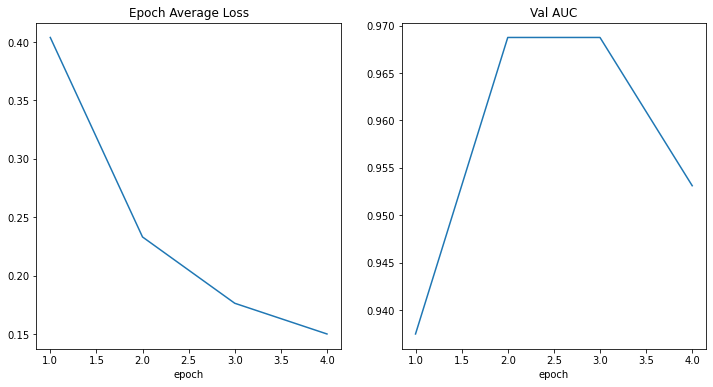

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Load best model and evaluate on test data

In [11]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [12]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

      NORMAL     0.9346    0.6111    0.7390       234
   PNEUMONIA     0.8068    0.9744    0.8827       390

    accuracy                         0.8381       624
   macro avg     0.8707    0.7927    0.8109       624
weighted avg     0.8547    0.8381    0.8288       624



# Save as ONNX for TensorRT and Triton

In [13]:
dummy_input = torch.randn(32, 1, 224, 224).to(device)

with torch.no_grad():
    print(model(dummy_input).shape)

torch.Size([32, 2])


In [14]:
torch.onnx.export(model, dummy_input, 'model.onnx')

# Save as TorchScript for MONAI Deploy

In [15]:
torch.jit.script(model).save("classifier.zip")

# Free Memory

In [ ]:
import os
os._exit(00)